In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel, MaternKernel
from skgpytorch.models import SVGPRegressor, SGPRegressor

In [3]:
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
# from utilities import plot
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
import time
import numpy as np

# from datasets.dataset_load import dataset_loader
from utilities import plot,fits,gmm,errors,predict,preprocess

# device = "cpu"
# torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type(torch.FloatTensor)


In [62]:
train ={#1:{
                #     'start_time': "2011-04-21" ,
                #     'end_time': "2011-05-21"
                # },
                3: {
                    'start_time': "2011-04-19" ,
                    'end_time': "2011-05-22"
                },
                # 2: {
                #     'start_time': "2011-04-21" ,
                #     'end_time': "2011-05-21"
                # },
                # 5: {
                #     'start_time': "2011-04-22" ,
                #     'end_time': "2011-06-01"
                # }
                }
test = {6: {
                    'start_time': "2011-05-25" ,
                    'end_time': "2011-06-13"
                }}
appliances = ["Refrigerator"]

In [4]:
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler


def dataset_load(appliances, train, test=None):
    x_train = []
    y_train = []
    x_train_timestamp = []
    n = 9
    units_to_pad = n // 2
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    # train
    for key, values in train.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_train.extend(x)
        y_train.extend(y)
        x_train_timestamp.extend(torch.Tensor(timestamp_train))


    x_train = jnp.array(x_train)
    y_train = jnp.array(y_train).reshape(-1, 1)
    x_train_timestamp = torch.Tensor(x_train_timestamp).reshape(-1,1)
    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)


    # test
    x_test = []
    y_test = []
    x_test_timestamp = []
    for key, values in test.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_test.extend(x)
        y_test.extend(y)
        x_test_timestamp.extend(timestamp)

    x_test = jnp.array(x_test)
    y_test = jnp.array(y_test).reshape(-1, 1)
    x_test_timestamp = torch.Tensor(x_test_timestamp).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)
#     y_test = scaler_y.transform(y_test)

    x_train = jnp.array(x_train).reshape(x_train.shape[0], n)
    y_train = jnp.array(y_train)
    x_train_timestamp = torch.Tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1)
    x_test = jnp.array(x_test).reshape(x_test.shape[0], n)
    y_test = jnp.array(y_test)
    x_test_timestamp = torch.Tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1)

    return x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y, scaler_time


In [11]:
train ={  3: {
          'start_time': "2011-04-19" ,
          'end_time': "2011-05-22"
    },
   
 
    2: {
    'start_time': "2011-04-21" ,
    'end_time': "2011-05-21"
}
}
test = {  1: {
          'start_time': "2011-04-28" ,
          'end_time': "2011-05-15"
        },
    

}
appliances = ["Dish Washer"]

In [5]:
train ={
    1: {
          'start_time': "2011-04-28" ,
          'end_time': "2011-05-15"
        },
    3: {
          'start_time': "2011-04-19" ,
          'end_time': "2011-05-22"
    }
}
test = {
     2: {
          'start_time': "2011-04-21" ,
          'end_time': "2011-05-21"
    }
}
appliances = ["Microwave"]

In [12]:
x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y, scaler_time = dataset_load(appliances, train, test)

## Microwave

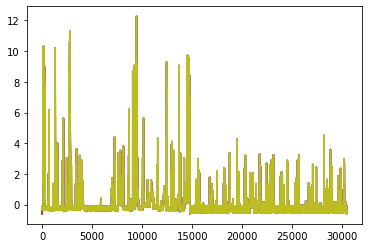

In [7]:
plt.plot(x_train)

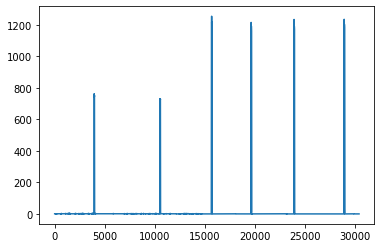

In [9]:
plt.plot(scaler_y.inverse_transform(y_train.reshape(-1,1)))

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

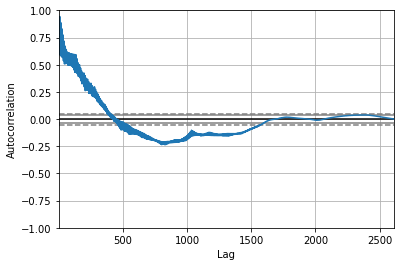

In [10]:
pd.plotting.autocorrelation_plot(pd.Series(x_train[:290].reshape(-1,)))

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

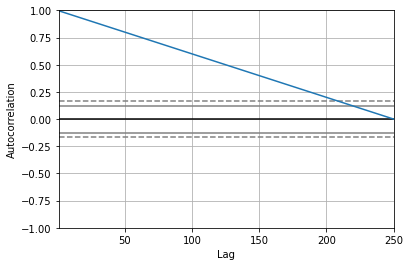

In [14]:
pd.plotting.autocorrelation_plot(pd.Series(y_train[:250].reshape(-1,)))

In [14]:
x = x_train[:10]

In [22]:
kenel = ScaleKernel(RBFKernel(ard_num_dims=9))
lazy_covar_matrix = kenel(torch.tensor(np.array(x)),torch.ones(10,9)) # Returns a RootLazyTensor
tensor_covar_matrix = lazy_covar_matrix.evaluate()

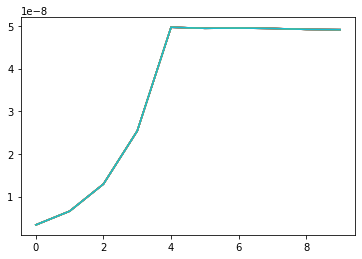

In [23]:
plt.plot(tensor_covar_matrix.detach().numpy())

## Dishwasher

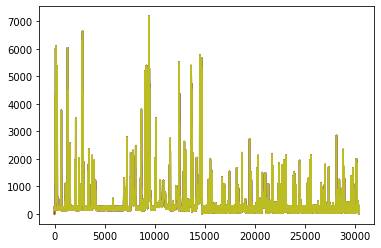

In [14]:
plt.plot(scaler_x.inverse_transform(x_train.reshape(-1,9)))

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

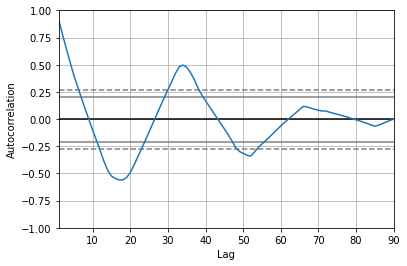

In [8]:
pd.plotting.autocorrelation_plot(pd.Series(x_train[:90].reshape(-1,)))

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

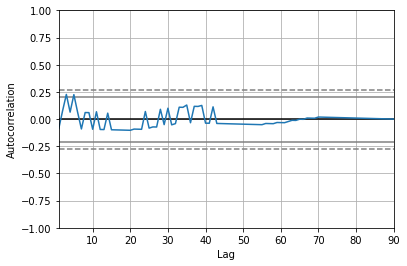

: 

In [10]:
pd.plotting.autocorrelation_plot(pd.Series(y_train[:90].reshape(-1,)))

## Refrigerator

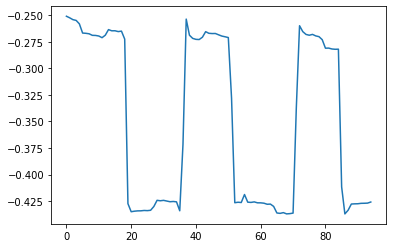

In [78]:
plt.plot(x_train[:100])

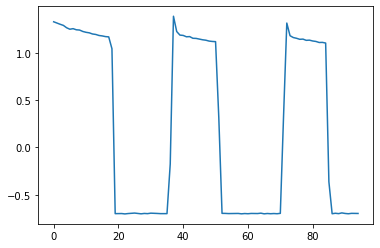

In [67]:
plt.plot(y_train[:500])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

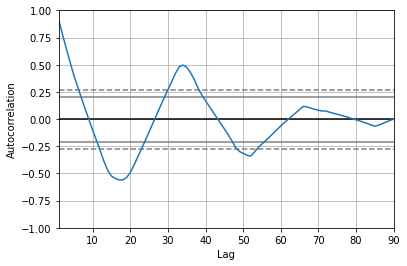

In [81]:
# eval = kernel(x_train[:500],torch.tensor(np.ones((500)))).evaluate().detach().numpy()
pd.plotting.autocorrelation_plot(pd.Series(x_train[:90].reshape(-1,)))

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

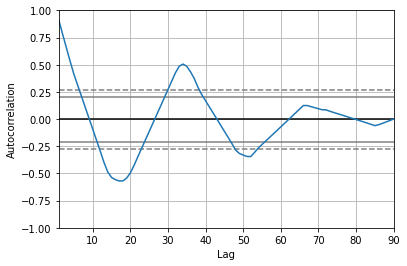

In [85]:
# eval = kernel(x_train[:500],torch.tensor(np.ones((500)))).evaluate().detach().numpy()
pd.plotting.autocorrelation_plot(pd.Series(y_train[:90].reshape(-1,)))

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

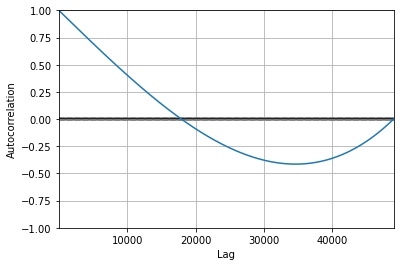

In [86]:
kernel = ScaleKernel(MaternKernel(nu=0.5))
# eval = kernel(x_train[:500],torch.tensor(np.ones((500)))).evaluate().detach().numpy()
pd.plotting.autocorrelation_plot(pd.Series(x_train_timestamp[:100000].reshape(-1,)))

In [25]:
from collections import Counter

In [ ]:
x_temp = x_train_timestamp[:500]

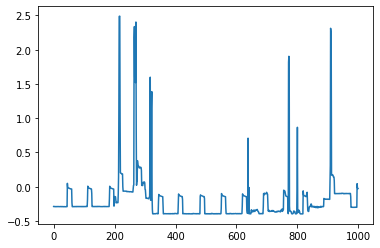

In [96]:
plt.plot(x_train[:1000])

In [43]:
a = np.array(x_train_timestamp).reshape(-1,)
b = a
Counter((b[1:] - a[:-1]))

Counter({7.760084275520995e-05: 21039,
         7.760084246788423e-05: 1732,
         7.7600842755432e-05: 1087,
         7.760084246810628e-05: 7259,
         7.760084246799526e-05: 2438,
         7.760084275532098e-05: 1487,
         7.760084275526546e-05: 1492,
         7.760084246805077e-05: 4128,
         7.760084246807852e-05: 1,
         7.760084275523771e-05: 1949,
         7.760084246802301e-05: 71,
         7.760084275522383e-05: 642,
         7.760084246803689e-05: 65,
         7.760084275523077e-05: 724,
         7.760084246804383e-05: 65,
         7.76008427552273e-05: 59,
         7.76008424680473e-05: 71,
         7.760084275522904e-05: 59,
         7.760084246804903e-05: 115,
         7.76008427552299e-05: 108,
         7.76008424680499e-05: 9,
         7.760084275523034e-05: 9,
         7.760084246804925e-05: 8,
         7.760084275523012e-05: 1,
         7.760084275523001e-05: 5,
         7.760084246804914e-05: 8,
         7.760084275522996e-05: 6,
         7.76008427